# ✅ Импорты

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklift.models import TwoModels
from sklift.metrics import (
    uplift_at_k,
    qini_auc_score,
    weighted_average_uplift,
    uplift_by_percentile
)

from upninja.utils.Viz import (
    plot_qini_curve,
    plot_uplift_by_percentile
)

import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Загрузим X5 Retail Hero dataset

In [3]:
DATA_PATH = 'data/retailhero-uplift/data'

In [4]:
%%time

clients = pd.read_csv(os.path.join(DATA_PATH, 'clients.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))
purchases = pd.read_csv(os.path.join(DATA_PATH, 'purchases.csv'))
train = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test.csv'))

CPU times: user 18.8 s, sys: 5.32 s, total: 24.2 s
Wall time: 26.2 s


## ⚒️ Препроцессинг X5 Retail Hero dataset

In [5]:
%%time

product_cols = ['product_id', 'is_alcohol', 'is_own_trademark']

purchases = purchases.merge(products[product_cols], 
                            on='product_id',
                            how='left'
                           )

purchases['transaction_datetime'] = pd.to_datetime(purchases['transaction_datetime'])

# агрегаты по клиенту:
client_features = purchases.groupby('client_id').agg(
    n_transactions=('transaction_id', 'nunique'),
    sum_trn_sum=('trn_sum_from_iss', 'sum'),
    mean_trn_sum=('trn_sum_from_iss', 'mean'),
    sum_quantity=('product_quantity', 'sum'),
    alcohol_bought=('is_alcohol', 'sum'),
    own_trademark_bought=('is_own_trademark', 'sum'),
    n_unique_products=('product_id', 'nunique'),
    n_days_active=('transaction_datetime', lambda x: x.nunique()),
    last_transaction_days_ago=('transaction_datetime', lambda x: (pd.Timestamp('2019-03-18') - x).max().days)
)

CPU times: user 36.5 s, sys: 2.28 s, total: 38.7 s
Wall time: 39.4 s


In [6]:
def parse_birthdate(client_id_str):
    if pd.isna(client_id_str):
        return pd.NaT
    s = str(client_id_str)[:6]
    if len(s) != 6 or not s.isdigit():
        return pd.NaT
    yy, mm, dd = s[:2], s[2:4], s[4:6]
    if mm in ('00', '99') or dd in ('00', '99'):
        return pd.NaT
    try:
        return pd.Timestamp(f'19{yy}-{mm}-{dd}')
    except ValueError:
        try:
            return pd.Timestamp(f'20{yy}-{mm}-{dd}')
        except ValueError:
            return pd.NaT

In [7]:
%%time

clients['first_issue_date'] = pd.to_datetime(clients['first_issue_date'])
clients['first_redeem_date'] = pd.to_datetime(clients['first_redeem_date'])

clients['issue_ts'] = clients['first_issue_date'].map(pd.Timestamp.timestamp)
clients['redeem_ts'] = clients['first_redeem_date'].apply(
    lambda x: x.timestamp() if pd.notna(x) else np.nan
)
clients['redeem_issue_diff'] = clients['redeem_ts'] - clients['issue_ts']
birth_dates = clients['client_id'].apply(parse_birthdate)
clients['age'] = (pd.Timestamp('2019-03-18') - birth_dates).dt.days / 365.25

CPU times: user 1.06 s, sys: 30.1 ms, total: 1.09 s
Wall time: 1.09 s


In [8]:
# объединяем с агрегатами:
train_full = train.merge(clients, on='client_id', how='left')
train_full = train_full.merge(client_features, on='client_id', how='left')

test_full = test.merge(clients, on='client_id', how='left')
test_full = test_full.merge(client_features, on='client_id', how='left')

In [9]:
train_full.to_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full.to_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

## ⚙️ Baseline

In [10]:
%%time

train_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

CPU times: user 330 ms, sys: 30.9 ms, total: 361 ms
Wall time: 360 ms


In [11]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 200039 non-null  int64  
 1   client_id                  200039 non-null  object 
 2   treatment_flg              200039 non-null  int64  
 3   target                     200039 non-null  int64  
 4   first_issue_date           200039 non-null  object 
 5   first_redeem_date          182493 non-null  object 
 6   age                        452 non-null     float64
 7   gender                     200039 non-null  object 
 8   issue_ts                   200039 non-null  float64
 9   redeem_ts                  182493 non-null  float64
 10  redeem_issue_diff          182493 non-null  float64
 11  n_transactions             200039 non-null  int64  
 12  sum_trn_sum                200039 non-null  float64
 13  mean_trn_sum               20

In [12]:
target_name = 'target'
treatment_name = 'treatment_flg'

baseline_selector = [
    feat for feat in train_full.select_dtypes(exclude='object').columns
         if feat not in ('id', 'Unnamed: 0', target_name, treatment_name)
         and not train_full[feat].isna().any().any()
]

baseline_selector

['issue_ts',
 'n_transactions',
 'sum_trn_sum',
 'mean_trn_sum',
 'sum_quantity',
 'alcohol_bought',
 'own_trademark_bought',
 'n_unique_products',
 'n_days_active',
 'last_transaction_days_ago']

In [13]:
train_full[baseline_selector].describe()

,issue_ts,n_transactions,sum_trn_sum,mean_trn_sum,sum_quantity,alcohol_bought,own_trademark_bought,n_unique_products,n_days_active,last_transaction_days_ago
count,2.000390e+05,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,1.515492e+09,20.120821,8398.786037,75.437531,142.527997,1.916926,17.433061,75.287259,20.120781,96.268868
std,1.759508e+07,17.732130,8627.434880,34.422622,140.550727,5.126671,19.139443,56.378792,17.732053,26.991088
min,1.491330e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
25%,1.500656e+09,8.000000,3096.000000,58.449771,53.000000,0.000000,5.000000,35.000000,8.000000,92.000000
50%,1.510779e+09,15.000000,5996.000000,70.309524,104.000000,0.000000,12.000000,62.000000,15.000000,109.000000
75%,1.529517e+09,27.000000,10863.000000,85.626551,188.000000,2.000000,23.000000,101.000000,27.000000,113.000000
max,1.552686e+09,320.000000,498973.000000,4427.000000,10614.000000,183.000000,489.000000,1364.000000,320.000000,116.000000


In [14]:
X_train_full = train_full[baseline_selector]
y_full = train_full[target_name]
treat_full = train_full[treatment_name]

X_test = test_full[[
    feat for feat in baseline_selector
         if feat not in ('target', 'treatment_flg', target_name, treatment_name)
]]

X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X_train_full, y_full, treat_full,
    test_size=0.2,
    random_state=42,
    stratify=treat_full.astype(str) + y_full.astype(str)
)

# Two-Model подход: обучаем отдельные модели для treatment и control
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=100, random_state=42),
    estimator_ctrl=RandomForestClassifier(n_estimators=100, random_state=42),
    method='vanilla'  # разность предсказаний: P(Y=1|X,T=1) - P(Y=1|X,T=0)
)

In [15]:
%%time

tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
    estimator_ctrl=RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
    method='vanilla'
)

tm.fit(X_train, y_train, treat_train)

uplift_val = tm.predict(X_val)

CPU times: user 29.3 s, sys: 365 ms, total: 29.7 s
Wall time: 3.29 s


## 🔮 Baseline Аналитика

### ⭐ Uplift at 30%

In [16]:
# ранжируем treatment и control отдельно:
#    -отбираем топ-30% клиентов по uplift’у, и среди них есть и treatment, и control

uplift_30 = uplift_at_k(
    y_true=y_val,
    uplift=uplift_val,
    treatment=treat_val,
    strategy='by_group',
    k=0.3
)
print(f'Uplift@30%: {uplift_30:.4f}')

Uplift@30%: 0.0548


### ⭐ Quini AUC

In [17]:
auqc = qini_auc_shape = qini_auc_score(y_val, uplift_val, treat_val)
print(f"Qini AUC (AUQC): {auqc:.4f}")

Qini AUC (AUQC): 0.0098


### ⭐ Weighted average uplift

In [18]:
wau = weighted_average_uplift(y_val, uplift_val, treat_val, bins=10)
print(f"Weighted Average Uplift: {wau:.4f}")

Weighted Average Uplift: 0.0336


### ⭐ Uplift by percentiles

In [19]:
uplift_bins = uplift_by_percentile(
    y_true=y_val,
    uplift=uplift_val,
    treatment=treat_val,
    strategy='overall',
    bins=10,
    std=True,
    total=False
)

pd.DataFrame(uplift_bins)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1975,2026,0.529114,0.464462,0.064652,0.011232,0.011080,0.015777
10-20,2003,1998,0.535696,0.484484,0.051212,0.011143,0.011181,0.015785
20-30,1966,2035,0.583927,0.538575,0.045352,0.011117,0.011051,0.015675
30-40,2075,1926,0.585060,0.571132,0.013928,0.010816,0.011277,0.015626
40-50,2029,1972,0.628388,0.581136,0.047252,0.010728,0.011110,0.015444
50-60,1988,2013,0.644869,0.605564,0.039305,0.010733,0.010893,0.015292
60-70,2006,1995,0.649551,0.653133,-0.003581,0.010653,0.010656,0.015068
70-80,2020,1981,0.719307,0.678950,0.040357,0.009998,0.010490,0.014491
80-90,1930,2070,0.758549,0.721256,0.037293,0.009742,0.009855,0.013857


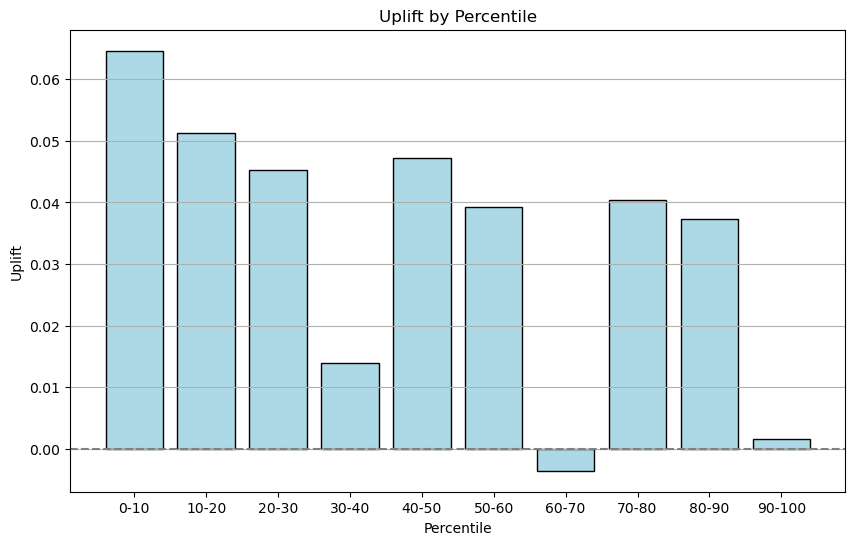

In [22]:
plot_uplift_by_percentile(
    y_val,
    uplift_val,
    treat_val
)
plt.show()

### Qini curve

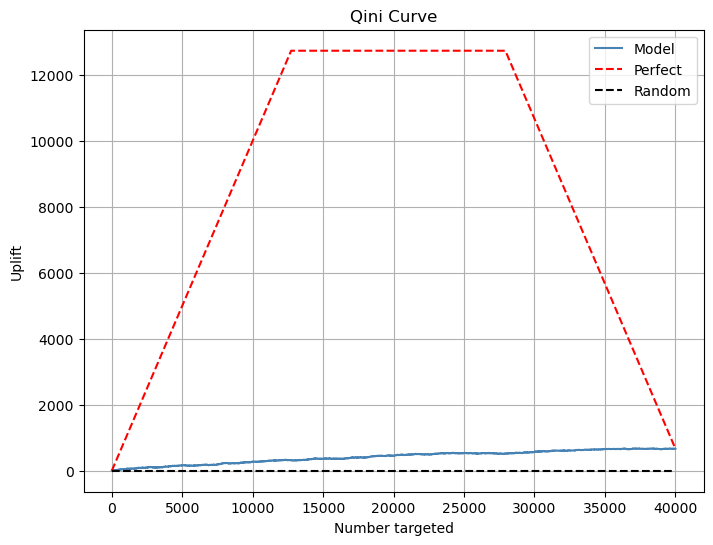

In [23]:
plot_qini_curve(y_val, uplift_val, treat_val, perfect=True)
plt.show()